In [ ]:
import ee
ee.Authenticate()

True

In [ ]:
#### connecting to my EEG cloud project account
ee.Initialize(project='emmanuella-gee-project')

In [3]:
# get December image, we're using the "avg_rad" band
viirs2019_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2019-12-01","2019-12-31").select('avg_rad').median()

In [4]:
import geemap, ee

In [5]:
# center on Catalonia
lat = 41.83
lon = 1.67

In [6]:
# initialize our map
map1 = geemap.Map(center=[lat,lon],zoom=7)
map1.add_basemap('SATELLITE')
map1.addLayer(viirs2019_12.mask(viirs2019_12), {}, "VIIRS-DNB Dec 2019")

In [7]:
map1.addLayerControl()
map1

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [ ]:
##################creating a histogram################

In [8]:
# create a 200 km buffer around the center of Catalonia
aoi = ee.Geometry.Point([lon, lat]).buffer(200000);

# extract a number array from this region
arr = geemap.ee_to_numpy(viirs2019_12, region=aoi)

In [9]:
import matplotlib.pyplot as plt

In [17]:
!pip install seaborn


[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import seaborn as sns

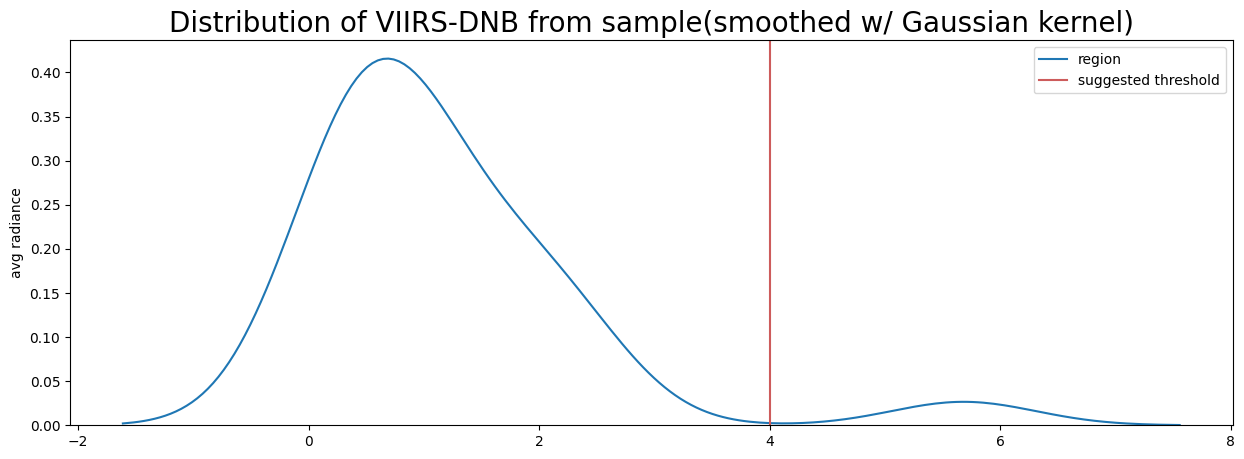

In [11]:
# create a histogram
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(arr.flatten(), label='region',legend=True, ax=ax)
ax.axvline(4, color='indianred', label='suggested threshold')
plt.legend(fontsize=20)
plt.title('Distribution of VIIRS-DNB from sample(smoothed w/ Gaussian kernel)', fontsize=20);
plt.ylabel('avg radiance')
plt.legend();

In [12]:
viirs2019_12_mask = viirs2019_12.gte(4)

In [13]:
# initialize our map
map2 = geemap.Map(center=[lat,lon],zoom=7)
map2.add_basemap('SATELLITE')

In [14]:
# we'll mask the image with itself to keep the visualization clean
map2.addLayer(viirs2019_12_mask.mask(viirs2019_12_mask), {}, "Avg rad >=4")
map2.addLayerControl()
map2

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [ ]:
##creating a map of zonesbased on chained boolean mask 

In [15]:
zones = viirs2019_12.gt(1.5).add(viirs2019_12.gt(2)).add(viirs2019_12.gt(5))

In [16]:
# initialize our map
map3 = geemap.Map(center=[lat,lon],zoom=7)
map3.add_basemap('SATELLITE')

map3.addLayer(zones.mask(zones), {'palette':['#cc0909','#e67525','#fff825']}, 'zones')

map3.addLayerControl()
map3

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [ ]:
##########################Cell statistics and basic band math####################################

In [17]:
# get December image, we're using the "avg_rad" band
viirs2017_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2017-12-01","2017-12-31").select('avg_rad').first()

In [18]:
# get the geometry for Timor-Leste from GEE's tagged datasets
tls = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Timor-Leste')).first()).geometry()

In [19]:
# clip our VIIRS image to Timor-Leste
ntl_tls = viirs2017_12.clip(tls)

In [20]:
# initialize our map and center it on Timor-Leste
map1 = geemap.Map()
map1.centerObject(tls, zoom=8)
map1.add_basemap('SATELLITE')
map1.addLayer(ntl_tls, {}, "VIIRS-DNB Dec 2017")
map1.addLayerControl()
map1

Map(center=[-8.820898657360543, 125.85269954324596], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
mu = ntl_tls.reduceRegion(reducer=ee.Reducer.mean())
std = ntl_tls.reduceRegion(reducer=ee.Reducer.stdDev())

In [22]:
#  casting these to native ee Numbers using the ee.Number constructor
mu = ee.Number(mu.get('avg_rad'))
std = ee.Number(std.get('avg_rad'))

In [23]:
# in order to confirm, we have to evaluate this to print client size (i.e. our computer)
print(f"the mean avg radiance (per month) for the pixels in our Timor-Leste region is: {mu.getInfo():.4f}")
print(f"the std dev is: {std.getInfo():.4f}")

the mean avg radiance (per month) for the pixels in our Timor-Leste region is: 0.2980
the std dev is: 0.6565


In [ ]:
###############creating a clean layer by subtracting the mean from our initial image and then dividing by the st. dev

In [24]:
ntl_tls_std = ntl_tls.subtract(mu).divide(std)

In [25]:
# create a split panel map
left_layer = geemap.ee_tile_layer(ntl_tls, {},'VIIRS-DNB 2017')
right_layer = geemap.ee_tile_layer(ntl_tls_std, {},'VIIRS-DNB 2017 (zero-centered and unit variance)')

In [26]:
map2 = geemap.Map()
map2.centerObject(tls, zoom=8)
map2.add_basemap('SATELLITE')
map2.split_map(left_layer=left_layer, right_layer=right_layer)
map2.addLayerControl()
map2

Map(center=[-8.820898657360543, 125.85269954324596], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
########################Expressions##################################################

In [27]:
lat_2 = 19.43
lon_2 = -99.13
map2_1 = geemap.Map(center=[lat,lon],zoom=6)
map2_1.add_basemap('SATELLITE')

In [28]:
# get 1996 composite, apply mask, and add as layer
dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996").select('stable_lights')
map2_1.addLayer(dmsp1996.mask(dmsp1996), {}, "DMSP-OLS 1996", opacity=0.75)
map2_1.addLayerControl()
map2_1

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [ ]:
#####################Inverting an image##########################################

In [30]:
dmsp1996_inv = dmsp1996.multiply(-1).add(63)

In [32]:
map2_2 = geemap.Map(center=[lat_2,lon_2],zoom=6)
map2_2.addLayerControl()

In [33]:
dmsp96_tile = geemap.ee_tile_layer(dmsp1996, {'min':0,'max':63}, 'DMSP NTL 1996', opacity=0.75)
dmsp96inv_tile = geemap.ee_tile_layer(dmsp1996_inv, {'min':0,'max':63}, 'DMSP NTL 1996 inverse', opacity=0.75)

map2_2.split_map(left_layer=dmsp96_tile, right_layer=dmsp96inv_tile)

map2_2

Map(center=[19.43, -99.13], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [34]:
# set our formula
F121996cal = '-0.0959 + (1.2727 * X) + (-0.0040 * X * X)'

# apply our expression to our 1996 composite
# dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996").select('stable_lights')
dmsp1996_clbr = dmsp1996.expression(F121996cal,{'X':dmsp1996})

In [35]:
map2_3 = geemap.Map(center=[lat,lon],zoom=9)
map2_3.addLayerControl()

mask96 = geemap.ee_tile_layer(dmsp1996.mask(dmsp1996), {'min':0,'max':63}, 'DMSP NTL 1996', opacity=0.75)
adj96 = geemap.ee_tile_layer(dmsp1996_clbr.mask(dmsp1996_clbr), {'min':0,'max':63}, 'DMSP NTL 1996 adjusted', opacity=0.75)

map2_3.split_map(left_layer=mask96, right_layer=adj96)
map2_3

Map(center=[41.83, 1.67], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [36]:
#### making simple VIRS-DNB annual composites

# get the 2015 image collection, we're using the "avg_rad" band
viirs2015 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2015-01-01","2015-12-31").select('avg_rad')

In [37]:
# as a gut-check, there should be 12 images in this collection!
print(f"there are {viirs2015.size().getInfo()} images in this collection")

there are 12 images in this collection


In [38]:
viirs2015med = viirs2015.median()

# iniatialize map on Sao Paulo
lat_3 = -23.54
lon_3 = -46.63

# initialize our map
map3_1 = geemap.Map(center=[lat,lon], zoom=8)

map3_1.add_basemap('SATELLITE')

map3_1.addLayer(viirs2015med.mask(viirs2015med), {}, "VIIRS-DNB 2015 (monthly med)")
map3_1.addLayerControl()
map3_1

Map(center=[41.83, 1.67], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright',…

In [39]:
####creating time series of annual composites from 2015 to 2019
# define our start and end years
start = 2015
end = 2019

years = ee.List.sequence(start, end)

print(f"our list has {years.size().getInfo()} years in it")

our list has 5 years in it


In [40]:
colID = "NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG"

def viirs_annual_median_reduce(year):
    return ee.ImageCollection(colID).filter(
        ee.Filter.calendarRange(year,year,"year")).select("avg_rad").median().set('year',year)

# map function to each year in our list
yearComps = ee.ImageCollection.fromImages(years.map(viirs_annual_median_reduce))

In [41]:
map3_2 = geemap.Map(center=[lat_3,lon_3], zoom=8)

map2.add_basemap('SATELLITE')

# add each layer
for year in range(start,end+1):
    img = yearComps.filterMetadata("year","equals",year).first() #there's only one image, but we extract from collection
    map3_2.addLayer(img.mask(img), {}, f"VIIRS-DNB {year}", opacity=.75)

In [42]:
map2.addLayerControl()
map2

Map(bottom=34680.0, center=[-8.820898657360543, 125.85269954324596], controls=(ZoomControl(options=['position'…

In [43]:
# create a split panel map
left_layer = geemap.ee_tile_layer(yearComps.filterMetadata("year","equals",2015), {},
                                  'VIIRS-DNB 2015', opacity=0.75)
right_layer = geemap.ee_tile_layer(yearComps.filterMetadata("year","equals",2019), {},
                                   'VIIRS-DNB 2019', opacity=0.75)

map3_3 = geemap.Map(center=[lat_3,lon_3], zoom=8)
map3_3.add_basemap('SATELLITE')
map3_3.split_map(left_layer=left_layer, right_layer=right_layer)
map3_3.addLayerControl()
map3_3

Map(center=[-23.54, -46.63], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…